### Imports

In [16]:
!pip install pyspark

# Spark function import
from pyspark.ml import feature, clustering, Pipeline, functions as fn, regression, evaluation
from pyspark.sql import SparkSession, functions as Row, SQLContext, types
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import udf, expr, concat, col
from string import punctuation
from pyspark.ml.feature import Tokenizer, StopWordsRemover, IDF, CountVectorizer
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
import re, requests


# Python function imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from textblob import TextBlob

In [17]:
MAX_MEMORY = "12g"

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

### Data Extraction into a Pandas dataframe

In [18]:
# We are extracting data before and after the election results that are scraped and stored in a separate CSV files on GitHub
before_url = "https://raw.githubusercontent.com/pratt-datar/IST_718/main/tweets.csv"

after_url = "https://raw.githubusercontent.com/pratt-datar/IST_718/main/tweet_after.csv"

In [19]:
# Data extraction in pandas dataframe
before_df = pd.read_csv(before_url)
after_df = pd.read_csv(after_url)

### Data Cleaning and Feature Engineering

In [5]:
def extraxt_hashtags(text):
  hashtags = re.findall(r'\B#\w*[a-zA-Z]+\w*', text)
  return hashtags

In [6]:
def clean_tweet(tweet):
  # Remove hyperlinks
  tweet = re.sub("https?://[A-Za-z0-9./]*","",tweet)
  # Remove hashtags
  tweet = re.sub(r'#\w*', '', tweet)
  # Remove tickers
  tweet = re.sub(r'\$\w*', '', tweet)
  #@user -> at_user
  tweet = re.sub("@[\w]*","",tweet)
  # To lowercase
  tweet = tweet.lower()
  # Remove Punctuation and split 's, 't, 've with a space for filter
  tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
  # Remove words: I, a , am, me (2 or less letters)
  tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
  # Remove whitespace (including new line characters)
  tweet = re.sub(r'\s\s+', ' ', tweet)
  # Remove single space remaining at the front of the tweet.
  tweet = tweet.lstrip(' ') 
  # Remove emojis or other. special characters
  tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
  return tweet

In [7]:
def clean_feature_engg(pandas_df):
  '''
  Converting pandas dataframe to Spark Dataframe to perform cleaning operations. We are removing retweeted tweets as they do not add any information value \
  and create bias by increasing document frequency for the words in the vocabulary that are heavily retweeted. 
  '''
  # Pandas to Spark
  mySchema = StructType([StructField("user", StringType())\
                      ,StructField("id", FloatType())\
                      ,StructField("location", StringType())\
                      ,StructField("date", StringType())\
                      ,StructField("favourites_count", StringType())\
                      ,StructField("text", StringType())\
                      ,StructField("retweet", StringType())])
  spark_df = spark.createDataFrame(pandas_df,schema=mySchema)

  # Dropping ID, Date, Favorites count column, removing retweeted tweets and dropping duplicates 
  spark_df = spark_df.drop('id', 'date', 'favourites_count', 'location').filter(spark_df['retweet'] == 'false').dropDuplicates().drop('retweet')

  # Extracting hashtags from the text column in the dataframe
  func_hash = udf(extraxt_hashtags, types.StringType())
  spark_df = spark_df.withColumn("hashtags", func_hash("text"))

  func_clean = udf(clean_tweet, types.StringType())

  # Data Cleaning on the text column in the dataframe
  clean_df = spark_df.withColumn("clean_text", func_clean("text")).drop('text')

  return clean_df

In [8]:
# Cleaned and feature engineered dataframes

cleaned_spark_before_df = clean_feature_engg(before_df)
cleaned_spark_after_df = clean_feature_engg(after_df)

### CountVectorizer Hyper-parameter tuning

In [48]:
def countvec_func(token_df, cv_stage):  
  # Hyper-param model
  hyper_param_model = Pipeline(stages=[cv_stage])

  # Fitting the pipeline
  fitted_model = hyper_param_model.fit(token_df)

  return fitted_model

In [49]:
def count_vec_hyp_tuning(cleaned_spark_df):
  '''
  Creating a function to formulate Hyperparameter tuning for the countvectorizer
  '''
  # getting the stop words list from the URL
  stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

  # Tokenizer stage where sentences would be converted to words
  tokenizer = Tokenizer()\
    .setInputCol("clean_text")\
    .setOutputCol("words")

  # Stop words filter stage would remove the common occuring words that have no information value
  sw_filter = StopWordsRemover()\
    .setStopWords(stop_words)\
    .setCaseSensitive(False)\
    .setInputCol("words")\
    .setOutputCol("filtered")

  general_pipe = Pipeline(stages=[tokenizer, sw_filter])

  # Fitting the pipeline
  general_model = general_pipe.fit(cleaned_spark_df)

  # Creating a new transformed dataframe
  token_df = general_model.transform(cleaned_spark_df)

  # MinDF Hyperparameter tuning
  mindf_list = []
  for mindf in range(1,25):
    cv = CountVectorizer(minDF= mindf)\
    .setInputCol("filtered")\
    .setOutputCol("tf")
    
    mindf_list.append(len(countvec_func(token_df = token_df, cv_stage = cv).stages[-1].vocabulary))

  plt.plot(range(1,10), mindf_list[0:9])
  plt.ylabel('Vocabulary size')
  plt.xlabel('Min_DF')
  plt.title("Min DF optimum value")
  plt.axvline(x= 3, color = 'r', linestyle = '--' ,label = 'Optimal MinDF')
  plt.show()

  # MaxDF Hyperparameter tuning
  maxdf_list = []
  for maxdf in range(1,100):
    cv = CountVectorizer(maxDF= maxdf/100)\
    .setInputCol("filtered")\
    .setOutputCol("tf")

    maxdf_list.append(len(countvec_func(token_df = token_df, cv_stage = cv).stages[-1].vocabulary))

  plt.plot(range(1,100), maxdf_list)
  plt.ylabel('Vocabulary size')
  plt.xlabel('Max_DF')
  plt.title("Max DF optimum value")
  plt.show()

  # MinTF Hyperparameter tuning
  mintf_list = []
  for mintf in range(1,100):
    cv = CountVectorizer(minTF= mintf/100)\
    .setInputCol("filtered")\
    .setOutputCol("tf")
    
    mintf_list.append(len(countvec_func(token_df = token_df, cv_stage = cv).stages[-1].vocabulary))

  plt.plot(range(1,100), mintf_list)
  plt.ylabel('Vocabulary size')
  plt.xlabel('Min_TF')
  plt.title("Min TF optimum value")
  plt.show()

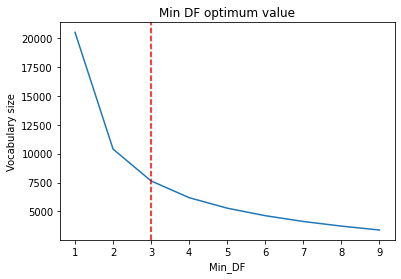

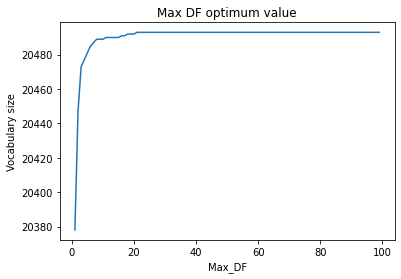

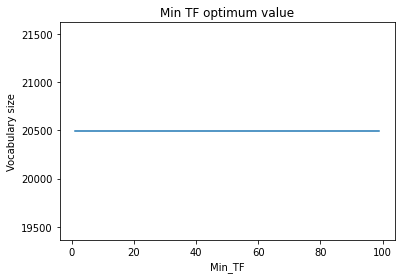

In [50]:
# Hyper-parameter tuning for before election dataframe
hyper_param_check = False

if hyper_param_check:
  count_vec_hyp_tuning(cleaned_spark_before_df)

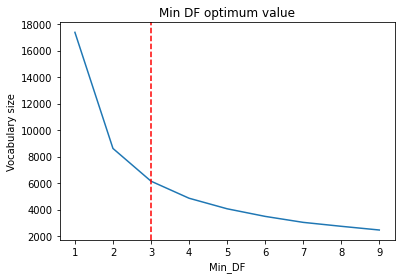

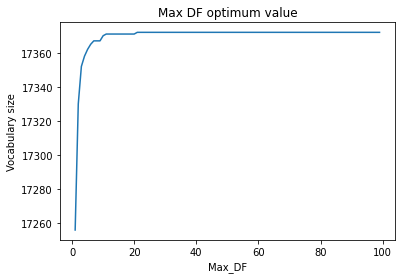

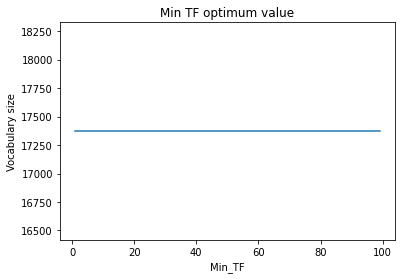

In [51]:
# Hyper-parameter tuning for after election dataframe
if hyper_param_check:
  count_vec_hyp_tuning(cleaned_spark_after_df)

### PCA (Variance Explained Graph)

In [12]:
# getting the stop words list from the URL
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

# Tokenizer stage where sentences would be converted to words
tokenizer = Tokenizer()\
  .setInputCol("clean_text")\
  .setOutputCol("words")

# Stop words filter stage would remove the common occuring words that have no information value
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# Introducding a count vectorizer what counts the frequency of words in a document and outputs a vector
cv = CountVectorizer(minDF=10., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

# Introducing a Inverse document frequency stage which in combination would give TF-IDF that gives less importance of occurence of non-stop words throughout most of the documents
# And assigns more importance to words that are less frequent
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

# standardize features
centered_tfidf = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')

In [72]:
def pca_var_graph_check(cleaned_spark_df, components):
  '''
  performs pca on the given dataframe and returns transformed dataframe
  '''
  # PCA
  pca = feature.PCA(k=components, inputCol='centered_tfidf', outputCol='scores')
  # Creating a pipeline
  pipe_pca = Pipeline(stages=[tokenizer, sw_filter, cv, idf, centered_tfidf, pca])

  # Fitting the pipeline
  model_pca = pipe_pca.fit(cleaned_spark_df)

  explained_var = model_pca.stages[-1].explainedVariance
  cum_sum = np.cumsum(explained_var)
  plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
  plt.title("Cumulative Sum of Variance Explained")
  plt.xlabel("Cumulative Components")
  plt.ylabel("Cumulative Sum of Variance Explained")
  plt.show()

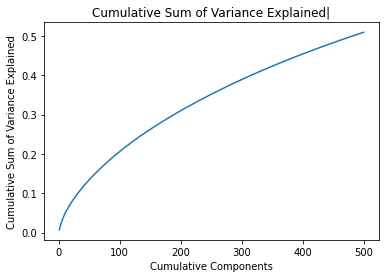

In [73]:
pca_check = False
if pca_check:
  pca_var_graph_check(cleaned_spark_df= cleaned_spark_before_df, components= 500)

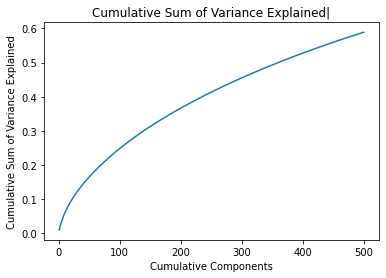

In [74]:
pca_var_graph_check(cleaned_spark_df= cleaned_spark_after_df, components= 500)

### KMeans Cluster Optimization with Silhouette Scores

In [9]:
def kmeans_silhouette(cleaned_spark_df):

  # User aggregation
  pandas_df = cleaned_spark_df.toPandas()
  pandas_df['clean_text'] = pandas_df.groupby('user')['clean_text'].transform(lambda x: ' + '.join(x))

  # Converting back to the Spark Dataframe
  mySchema = StructType([StructField("user", StringType())\
                        ,StructField("hashtags", StringType())\
                        ,StructField("clean_text", StringType())])
  cleaned_spark_df = spark.createDataFrame(pandas_df,schema=mySchema)

  # PCA
  pca = feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')
  centered_scores = feature.StandardScaler(withMean=True, withStd=False, inputCol='scores', outputCol='centered_scores')
  norm_scores = feature.Normalizer(inputCol="centered_scores", outputCol="norm_scores", p=2.0)

  # Creating a pipeline
  norm_score_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, centered_tfidf, pca, centered_scores, norm_scores])

  # Fitting and transforming the pipeline 
  model = norm_score_pipe.fit(cleaned_spark_df)

  norm_df = model.transform(cleaned_spark_df)

  evaluator = ClusteringEvaluator(predictionCol = 'kmeans', featuresCol="norm_scores",metricName="silhouette")

  # Creating a list to store silhouette scores for every K from 2 to 6
  silhouette_list = []
  for i in range(2,7):
    print("K = {}".format(i))
    # Since K-means start with random points for cluster creation, it is the best practice to try K-means clustering several times to choose the best silhouette score for every K
    silhouette_internal = []
    for j in range(1,3):
      print("Training time = {}".format(j))
      # Setting a random seed every time so that we can get different silhouette scores and then choose the best one
      kmeans = clustering.KMeans(k=i, featuresCol='norm_scores', predictionCol= 'kmeans').setSeed(j)
      pipeline = Pipeline(stages=[kmeans])
      
      # Fitting and transforming the pipeline on the chars_pca_df 
      kmeans_model = pipeline.fit(norm_df)

      # Creating silhouette scores for every round of training
      score = evaluator.evaluate(kmeans_model.transform(norm_df))
      print(score)
      silhouette_internal.append(score)
    
    # Choosing the best silhouette score for every K
    silhouette_list.append(min(silhouette_internal))

  return silhouette_list

In [78]:
kmeans_check = False
if kmeans_check:
  silhouette_list_before = kmeans_silhouette(cleaned_spark_before_df)

K = 2
Training time = 1
0.855662769123031
Training time = 2
0.8556678989946458
K = 3
Training time = 1
0.8520713354860115
Training time = 2
0.8520713354860115
K = 4
Training time = 1
0.8353742932230379
Training time = 2
0.8368773679653675
K = 5
Training time = 1
0.7477624176059846
Training time = 2
0.7437089501402864
K = 6
Training time = 1
0.7162284558377712
Training time = 2
0.7535777610823435


In [77]:
if kmeans_check:
  silhouette_list_after = kmeans_silhouette(cleaned_spark_after_df)

K = 2
Training time = 1
0.7102058778438398
Training time = 2
0.7102058778438398
K = 3
Training time = 1
0.7849041364572922
Training time = 2
0.7852398301414759
K = 4
Training time = 1
0.7198799152977863
Training time = 2
0.7202914637836512
K = 5
Training time = 1
0.6859904669937363
Training time = 2
0.7633556193013374
K = 6
Training time = 1
0.6566784594878483
Training time = 2
0.7422715656244799


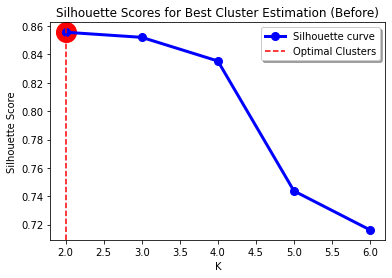

In [79]:
if kmeans_check:
  plt.plot(range(2,7), silhouette_list_before, "bo-", color = "blue", linewidth = 3, markersize = 8, label = 'Silhouette curve')
  plt.xlabel("K")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Scores for Best Cluster Estimation (Before)")
  k = np.argmax(silhouette_list_before) + 2
  plt.axvline(x= k, color = 'r', linestyle = '--' ,label = 'Optimal Clusters')
  plt.legend(loc = 'upper right', shadow = True)
  plt.scatter(k, silhouette_list_before[k -2], c = 'red', s = 400)
  plt.show()

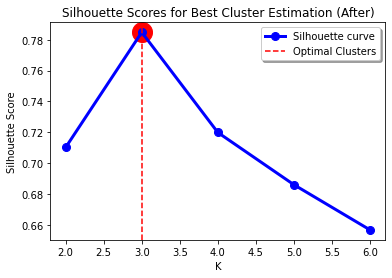

In [80]:
if kmeans_check:
  plt.plot(range(2,7), silhouette_list_after, "bo-", color = "blue", linewidth = 3, markersize = 8, label = 'Silhouette curve')
  plt.xlabel("K")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Scores for Best Cluster Estimation (After)")
  k = np.argmax(silhouette_list_after) + 2
  plt.axvline(x= k, color = 'r', linestyle = '--' ,label = 'Optimal Clusters')
  plt.legend(loc = 'upper right', shadow = True)
  plt.scatter(k, silhouette_list_after[k -2], c = 'red', s = 400)
  plt.show()

### Kmeans PCA Graph

In [13]:
def kmeans_pca_graph(cleaned_spark_df, clusters):

  # User aggregation
  pandas_df = cleaned_spark_df.toPandas()
  pandas_df['clean_text'] = pandas_df.groupby('user')['clean_text'].transform(lambda x: ' + '.join(x))

  # Converting back to the Spark Dataframe
  mySchema = StructType([StructField("user", StringType())\
                        ,StructField("hashtags", StringType())\
                        ,StructField("clean_text", StringType())])
  cleaned_spark_df = spark.createDataFrame(pandas_df,schema=mySchema)
  
  # PCA
  pca = feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')
  centered_scores = feature.StandardScaler(withMean=True, withStd=False, inputCol='scores', outputCol='centered_scores')
  norm_scores = feature.Normalizer(inputCol="centered_scores", outputCol="norm_scores", p=2.0)
  kmeans = clustering.KMeans(k=clusters, featuresCol='norm_scores', predictionCol= 'kmeans')

  # Creating a pipeline
  kmeans_pca_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, centered_tfidf, pca, centered_scores, norm_scores, kmeans])

  # Fitting and transforming the pipeline 
  model = kmeans_pca_pipe.fit(cleaned_spark_df)

  kmeans_df = model.transform(cleaned_spark_df)

  # Creating a list of user_names
  user_names = np.array(kmeans_df.select('user').rdd.map(lambda x: x['user']).collect())

  # Creating a list of scores 
  scores = np.array(kmeans_df.select('scores').rdd.map(lambda x: x['scores']).collect())

  kmeans_cluster = np.array(kmeans_df.select('kmeans').rdd.map(lambda x: x['kmeans']).collect())

  df_viz = pd.DataFrame({'PC1': scores[:,0], 'PC2': scores[:,1], 'user': user_names, 'kmean_cls': kmeans_cluster})

  fig = px.scatter(df_viz, x='PC1', y='PC2', color="kmean_cls", hover_data= ['user'], title= 'PCA with K-means')
  fig.update_traces(textposition='top center')
  fig.show()

In [14]:
kmeans_pca_graph(cleaned_spark_before_df, clusters= 2)

In [15]:
kmeans_pca_graph(cleaned_spark_after_df, clusters= 4)

### Hashtag Analysis

In [98]:
def hashtag_count(hashtags_pd):
  hash_list = []
  for i in range(0,len(hashtags_pd)):
    for j in hashtags_pd.hashtags[i]: 
      if j != '':
        hash_list.append(j)
  hashtags_agg_df = pd.DataFrame({"hashtags": hash_list, "index": [i for i in range(0, len(hash_list))]})
  return hashtags_agg_df.groupby('hashtags').count().reset_index().sort_values(by = 'index', ascending=False).reset_index(drop = True)

In [99]:
def hashtags_analysis_func(cleaned_spark_df):
  hashtags_pd = cleaned_spark_df.toPandas()
  hashtags_pd['hashtags'] = hashtags_pd.hashtags.str.lower()
  def str_to_list(ratings_str):
    return ratings_str.strip('][').split(', ')
  hashtags_pd['hashtags'] = hashtags_pd.hashtags.apply(str_to_list)

  return hashtag_count(hashtags_pd)

In [100]:
# Hashtag Distribution before the election
hashtags_analysis_func(cleaned_spark_before_df)[0:10]

,hashtags,index
0,#election2020,6496
1,#trump,3082
2,#donaldtrump,2306
3,#biden2020,2157
4,#vote,1911
5,#biden,1824
6,#kamalaharris,1667
7,#debate2020,1535
8,#joebiden,1011
9,#harris,966


In [101]:
# Hashtag Distribution before the election
hashtags_analysis_func(cleaned_spark_after_df)[0:10]

,hashtags,index
0,#vote2020,3189
1,#uselection2020,2903
2,#election2020,1956
3,#biden2020,1772
4,#trump,1769
5,#joebiden,1580
6,#biden,1521
7,#donaldtrump,1463
8,#uselection,969
9,#trump2020,693


###### Hashtag Analysis by Cluster

In [102]:
def kmeans_transform(cleaned_spark_df, clusters):
  # PCA
  pca = feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')
  centered_scores = feature.StandardScaler(withMean=True, withStd=False, inputCol='scores', outputCol='centered_scores')
  norm_scores = feature.Normalizer(inputCol="centered_scores", outputCol="norm_scores", p=2.0)
  kmeans = clustering.KMeans(k=clusters, featuresCol='norm_scores', predictionCol= 'kmeans')

  # Creating a pipeline
  kmeans_pca_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, centered_tfidf, pca, centered_scores, norm_scores, kmeans])

  # Fitting and transforming the pipeline 
  model = kmeans_pca_pipe.fit(cleaned_spark_df)

  kmeans_df = model.transform(cleaned_spark_df)

  return kmeans_df

In [103]:
kmeans_before_df = kmeans_transform(cleaned_spark_before_df, clusters=2)

In [104]:
kmeans_after_df = kmeans_transform(cleaned_spark_after_df, clusters=4)

In [113]:
def hashtags_cluster_analysis(kmeans_df):
  for i in range(0, len(set(kmeans_df.toPandas()['kmeans']))):
    cluster_df = kmeans_df[kmeans_df['kmeans'] == i]
    display(hashtags_analysis_func(cluster_df)[0:10])

In [114]:
# hashtags distribution before the election
hashtags_cluster_analysis(kmeans_before_df)

,hashtags,index
0,#election2020,1244
1,#biden2020,552
2,#trump,545
3,#biden,505
4,#kamalaharris,436
5,#vote,402
6,#donaldtrump,331
7,#joebiden,307
8,#debate2020,301
9,#harris,289


,hashtags,index
0,#election2020,5252
1,#trump,2537
2,#donaldtrump,1975
3,#biden2020,1605
4,#vote,1509
5,#biden,1319
6,#debate2020,1234
7,#kamalaharris,1231
8,#vote2020,740
9,#joebiden,704


In [115]:
# hashtags distribution before the election
hashtags_cluster_analysis(kmeans_after_df)

,hashtags,index
0,#vote2020,394
1,#votelikeyourlifedependsonit,191
2,#music,191
3,#countrymusic,190
4,#song,190
5,#behappy,169
6,#election2020,148
7,#florida,147
8,#thanks,145
9,#biden2020,144


,hashtags,index
0,#uselection2020,213
1,#vote2020,195
2,#election2020,154
3,#joebiden,150
4,#trump,150
5,#biden2020,134
6,#biden,132
7,#donaldtrump,129
8,#uselection,65
9,#bidenharris2020,54


,hashtags,index
0,#uselection2020,1189
1,#vote2020,1154
2,#trump,809
3,#election2020,744
4,#biden2020,665
5,#joebiden,654
6,#biden,634
7,#donaldtrump,624
8,#uselection,440
9,#trump2020,280


,hashtags,index
0,#vote2020,1446
1,#uselection2020,1374
2,#election2020,910
3,#biden2020,829
4,#trump,720
5,#joebiden,660
6,#biden,632
7,#donaldtrump,625
8,#uselection,428
9,#trump2020,338


### Target Label Generation

In [117]:
def get_tweet_sentiment(tweet): 
    '''Utility function to classify sentiment of passed tweet using textblob's sentiment method'''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return '1'
    elif analysis.sentiment.polarity < 0: 
        return '0'
    else:
      return '-1'

In [146]:
def generate_target(cleaned_spark_df):

  # Converting spark to a pandas dataframe for label generation
  cleaned_before_pd = cleaned_spark_df.toPandas()
  cleaned_before_pd['tb_label']= cleaned_before_pd['clean_text'].apply(lambda x: get_tweet_sentiment(x))
  
  # Changing data type of target label to int
  cleaned_before_pd['tb_label'] = cleaned_before_pd.tb_label.apply(int)
  
  # Removing neutral tweets and labelled positive as 1 and negative as 0
  cleaned_before_pd = cleaned_before_pd[cleaned_before_pd['tb_label'] != -1]

  # Converting back to the Spark Dataframe
  mySchema = StructType([StructField("user", StringType())\
                        ,StructField("hashtags", StringType())\
                        ,StructField("clean_text", StringType())\
                        ,StructField("tb_label", IntegerType())])
  return spark.createDataFrame(cleaned_before_pd,schema=mySchema)

In [147]:
labelled_before_df = generate_target(cleaned_spark_df= cleaned_spark_before_df)

In [148]:
labelled_after_df = generate_target(cleaned_spark_df= cleaned_spark_after_df)

### Logistic Regression

In [133]:
lr = LogisticRegression().\
    setLabelCol('tb_label').\
    setFeaturesCol('tfidf')

In [139]:
def grid_search_lr(labelled_df):
  # building a grid and adding parameters
  paramGrid = ParamGridBuilder() \
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
  .addGrid(lr.regParam, [0.0, 0.5, 1.0, 2.0]) \
  .build()
  evaluator = BinaryClassificationEvaluator(labelCol="tb_label", metricName="areaUnderROC")
  # Creating a new pipeline
  lr_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, lr])

  crossval = CrossValidator(estimator=lr_pipe, 
                        estimatorParamMaps=paramGrid, 
                        evaluator=evaluator, 
                        numFolds=3)

  # fitting the cross-validation object
  lr_model = crossval.fit(labelled_df)

  # Printing best regularization parameters
  print(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)])

In [140]:
grid_search = False
if grid_search:
  grid_search_lr(labelled_before_df)

{Param(parent='LogisticRegression_c12ee6bee9da', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_c12ee6bee9da', name='regParam', doc='regularization parameter (>= 0).'): 0.5}


In [141]:
if grid_search:
  grid_search_lr(labelled_after_df)

{Param(parent='LogisticRegression_c12ee6bee9da', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_c12ee6bee9da', name='regParam', doc='regularization parameter (>= 0).'): 0.5}


In [149]:
def reg_lr_top_words(labelled_df):
  # creating new Logistic Regression stage
  lr_reg = LogisticRegression().\
          setLabelCol('tb_label').\
          setFeaturesCol('tfidf').\
          setRegParam(0.5).\
          setElasticNetParam(0)
          
  # Creating a pipeline for regularized Logistic Regression
  lr_reg_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, lr_reg])

  reg_lr_model = lr_reg_pipe.fit(labelled_df)

  # Finding top words in the regularized model
  weights = reg_lr_model.stages[-1].coefficients.toArray()
  display(pd.DataFrame({'Negative word': reg_lr_model.stages[-3].vocabulary, 'score': weights}).sort_values(by = ['score'])[0:10].reset_index(drop = True))
  display(pd.DataFrame({'Positive word': reg_lr_model.stages[-3].vocabulary, 'score': weights}).sort_values(by = ['score'])[-10:].reset_index(drop = True))

In [150]:
# Top positive and negative words before the election
reg_lr_top_words(labelled_before_df)

,Negative word,score
0,worst,-0.144012
1,corrupt,-0.132141
2,outrageous,-0.128522
3,boring,-0.127508
4,insane,-0.126952
5,pathetic,-0.124976
6,terrible,-0.122350
7,disgusting,-0.122205
8,disappointed,-0.121327
9,crap,-0.121073


,Positive word,score
0,proud,0.072794
1,right,0.072888
2,nice,0.074059
3,lol,0.076070
4,good,0.078195
5,better,0.081684
6,win,0.087409
7,love,0.089324
8,best,0.096129
9,great,0.101759


In [151]:
# Top positive and negative words after the election
reg_lr_top_words(labelled_after_df)

,Negative word,score
0,fucking,-0.140101
1,moron,-0.138700
2,violent,-0.133689
3,insane,-0.130664
4,fake,-0.129026
5,sorry,-0.127712
6,false,-0.126255
7,crap,-0.126070
8,bad,-0.125830
9,stupidity,-0.125397


,Positive word,score
0,free,0.069341
1,interesting,0.070580
2,proud,0.072433
3,happy,0.072708
4,nice,0.074199
5,great,0.085121
6,good,0.088222
7,best,0.088897
8,elect,0.089673
9,win,0.093586


### Random Forest

In [157]:
def grid_search_rf(labelled_df):
  # Train a RandomForest model
  rf = RandomForestClassifier(featuresCol="tfidf", labelCol='tb_label')

  # Creating a new pipeline
  rf_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, rf])

  # building a grid and adding parameters
  paramGrid = ParamGridBuilder() \
  .addGrid(rf.maxDepth, [5, 7, 9]) \
  .addGrid(rf.numTrees, [20, 25, 30]) \
  .build()

  evaluator = BinaryClassificationEvaluator(labelCol="tb_label", metricName="areaUnderROC")

  # cross validation object
  crossval = CrossValidator(estimator = rf_pipe, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

  cvModel = crossval.fit(labelled_df)

  print("Optimum Maxdepth for the model is {}".format(cvModel.bestModel.stages[-1].getOrDefault('maxDepth')))
  print("Optimum NumTrees for the model is {}".format(cvModel.bestModel.stages[-1].getNumTrees))

In [158]:
grid_search = False
if grid_search:
  grid_search_rf(labelled_before_df)

Optimum Maxdepth for the model is 9
Optimum NumTrees for the model is 30


In [159]:
if grid_search:
  grid_search_rf(labelled_after_df)

Optimum Maxdepth for the model is 9
Optimum NumTrees for the model is 30


In [164]:
def rf_feature_importance(labelled_df):
  reg_rf = RandomForestClassifier(featuresCol="tfidf", labelCol='tb_label', maxDepth= 9, numTrees=30)

  # Creating a new pipeline
  reg_rf_pipe = Pipeline(stages=[tokenizer, sw_filter, cv, idf, reg_rf])

  # Fitting the optimized random forest model
  reg_rf_model = reg_rf_pipe.fit(labelled_df)

  # Extracting the feature importance for the words
  importance = reg_rf_model.stages[-1].featureImportances

  display(pd.DataFrame({'Word': reg_rf_model.stages[-3].vocabulary, 'importance': importance}).sort_values('importance', ascending = False)[0:10])

In [165]:
rf_feature_importance(labelled_before_df)

,Word,importance
124,corrupt,0.057622
43,win,0.037867
21,good,0.037519
238,fuck,0.034730
340,worst,0.033349
405,sick,0.031052
30,great,0.030854
213,stupid,0.029556
321,sorry,0.027059
92,bad,0.026757


In [166]:
rf_feature_importance(labelled_after_df)

,Word,importance
15,win,0.040424
41,sweet,0.036061
182,bad,0.033841
283,stupid,0.030447
236,wrong,0.028830
242,fuck,0.027503
297,fucking,0.026415
388,idiots,0.025337
381,sorry,0.024279
146,hate,0.024103
